In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

seed = 10676128  # Set random seed for reproducibility



In [43]:
# -----------------
# Utility Functions
# -----------------

def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def compute_r2(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

def normal_regression(X_train, y_train):
    # (X^T X)^(-1) X^T y
    return np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

def ridge_regression(X_train, y_train, alpha):
    # (X^T X + alpha * I)^(-1) X^T y
    n_features = X_train.shape[1]
    identity = np.eye(n_features)
    # We often do not regularize the bias term => set identity[0, 0] = 0
    identity[0, 0] = 0
    return np.linalg.inv(X_train.T @ X_train + alpha * identity) @ X_train.T @ y_train

def lasso_regression(X_train, y_train, alpha, max_iter=10000, tol=1e-6):
    """
    Coordinate Descent for Lasso.
    Note: For real-world usage, consider sklearn.linear_model.Lasso.
    """
    m, n = X_train.shape
    beta = np.zeros(n)
    for _ in range(max_iter):
        beta_old = beta.copy()
        for j in range(n):
            residual = y_train - X_train @ beta + X_train[:, j] * beta[j]
            rho = X_train[:, j].T @ residual
            if j == 0:  # Intercept (no regularization)
                beta[j] = rho / (X_train[:, j].T @ X_train[:, j])
            else:
                # Soft-thresholding
                beta[j] = np.sign(rho) * max(0, abs(rho) - alpha) / (X_train[:, j].T @ X_train[:, j])
        if np.max(np.abs(beta - beta_old)) < tol:
            break
    return beta

def plot_feature_vs_dependent(df, dependent_var):
    """
    Generates scatter plots for each feature in the DataFrame against the dependent variable.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        dependent_var (str): The dependent variable column name.

    Returns:
        None
    """
    # Exclude the dependent variable from the features
    features = df.columns.drop([dependent_var])

    # Define number of rows and columns for subplots
    n_features = len(features)
    n_cols = 3  # Number of columns in the subplot grid
    n_rows = -(-n_features // n_cols) # Ceiling division
    
    # Set figure size based on rows and columns
    plt.figure(figsize=(20, 5 * n_rows))

    # Create a scatterplot for each feature
    for idx, feature in enumerate(features, start=1):
        plt.subplot(n_rows, n_cols, idx)
        sns.scatterplot(x=df[feature], y=df[dependent_var])
        plt.title(f'{dependent_var} vs {feature}')
        plt.xlabel(feature)
        plt.ylabel(dependent_var)
        plt.grid(True)

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

# Forward Feature Selection

def plot_forward_selection_results(results_df):
    """
    Plots RMSE and R² over the number of features selected.
    """
    plt.figure(figsize=(12, 6))

    # RMSE plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(results_df) + 1), results_df['RMSE'], marker='o', label='RMSE')
    plt.title('Forward Feature Selection: RMSE')
    plt.xlabel('Number of Features Selected')
    plt.ylabel('RMSE')
    plt.grid(True)

    # R² plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(results_df) + 1), results_df['R2'], marker='o', label='R²')
    plt.title('Forward Feature Selection: R²')
    plt.xlabel('Number of Features Selected')
    plt.ylabel('R²')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def forward_feature_selection_kfold(X, y, k=5, max_features=None):
    """
    Perform forward feature selection using k-fold cross-validation.

    Parameters:
    - X: DataFrame of features
    - y: Series of target variable
    - k: Number of folds for cross-validation
    - max_features: Max number of features to select. If None, selects all.

    Returns:
    - selected_features: List of features selected in order
    - results: List of results for each increment of feature selection
    """
    remaining_features = list(X.columns)
    selected_features = []
    results = []
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    while remaining_features:
        best_rmse = float('inf')
        best_feature = None
        best_betas = None
        best_alpha = None
        
        for feature in remaining_features:
            # Subset with current selected + new feature
            X_temp = X[selected_features + [feature]]
            rmse_list = []
            r2_list = []
            
            for train_idx, val_idx in kf.split(X_temp):
                X_train_fold = X_temp.iloc[train_idx]
                X_val_fold   = X_temp.iloc[val_idx]
                y_train_fold = y.iloc[train_idx]
                y_val_fold   = y.iloc[val_idx]
                
                model = LinearRegression()
                model.fit(X_train_fold, y_train_fold)
                
                y_pred_fold = model.predict(X_val_fold)
                rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
                r2_fold   = r2_score(y_val_fold, y_pred_fold)
                
                rmse_list.append(rmse_fold)
                r2_list.append(r2_fold)
            
            avg_rmse = np.mean(rmse_list)
            avg_r2   = np.mean(r2_list)
            
            if avg_rmse < best_rmse:
                best_rmse   = avg_rmse
                best_feature = feature
                best_betas   = model.coef_
                best_alpha   = model.intercept_
        
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        
        results.append([
            selected_features.copy(),
            best_betas,
            best_alpha,
            best_rmse,
            avg_r2
        ])
        
        if max_features is not None and len(selected_features) >= max_features:
            break

    return selected_features, results

In [44]:
# -----------------
# Main Classes - RegressionAnalysis(Regression) and PepperAnalysis(Classification)
# -----------------

class RegressionAnalysis:
    def __init__(self, X, y, alphas=None, seed=seed, n_splits=5):
        """
        X, y: features and target arrays
        alphas: array-like of alpha values for Ridge/Lasso
        seed: random seed for reproducibility
        n_splits: number of splits for cross-validation
        """
        self.X = X
        self.y = y
        self.seed = seed
        self.n_splits = n_splits
        self.results_cv = []
        self.results_test = []

        if alphas is None:
            self.alphas = np.array([0.00001, 0.0001, 0.001, 0.01, 
                                    0.1, 1, 2, 5, 10, 20, 100, 1000])
        else:
            self.alphas = alphas

    def cross_validate(self):
        """
        Perform KFold cross-validation on the entire dataset (X, y)
        for Normal, Ridge, Lasso across each alpha (for Ridge/Lasso).
        We store all fold results in self.results_cv as tuples:
          (model_type, alpha, fold_idx, rmse, r2, betas).
        """
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.seed)
        self.results_cv = []
        
        fold_num = 1
        for train_index, val_index in kf.split(self.X):
            X_train, X_val = self.X[train_index], self.X[val_index]
            y_train, y_val = self.y[train_index], self.y[val_index]

            # Scale
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)

            # Add intercept
            X_train_scaled = np.hstack((np.ones((X_train_scaled.shape[0], 1)), X_train_scaled))
            X_val_scaled = np.hstack((np.ones((X_val_scaled.shape[0], 1)), X_val_scaled))

            # 1) Normal Regression
            beta_normal = normal_regression(X_train_scaled, y_train)
            y_pred_normal = X_val_scaled @ beta_normal
            rmse_normal = compute_rmse(y_val, y_pred_normal)
            r2_normal = compute_r2(y_val, y_pred_normal)
            self.results_cv.append(('Normal', None, fold_num, rmse_normal, r2_normal, beta_normal))

            # 2) Ridge for each alpha
            for alpha in self.alphas:
                beta_ridge = ridge_regression(X_train_scaled, y_train, alpha)
                y_pred_ridge = X_val_scaled @ beta_ridge
                rmse_ridge = compute_rmse(y_val, y_pred_ridge)
                r2_ridge = compute_r2(y_val, y_pred_ridge)
                self.results_cv.append(('Ridge', alpha, fold_num, rmse_ridge, r2_ridge, beta_ridge))

            # 3) Lasso for each alpha
            for alpha in self.alphas:
                beta_lasso = lasso_regression(X_train_scaled, y_train, alpha)
                y_pred_lasso = X_val_scaled @ beta_lasso
                rmse_lasso = compute_rmse(y_val, y_pred_lasso)
                r2_lasso = compute_r2(y_val, y_pred_lasso)
                self.results_cv.append(('Lasso', alpha, fold_num, rmse_lasso, r2_lasso, beta_lasso))
            
            fold_num += 1

    def get_cv_results_df(self):
        """Return cross-validation results as a pandas DataFrame."""
        columns = ['Model','Alpha','Fold','RMSE','R2','Betas']
        return pd.DataFrame(self.results_cv, columns=columns)

    def pick_best_alpha(self, model_type='Ridge', metric='RMSE'):
        """
        From cross-validation results, pick the alpha that has the best
        (lowest) mean RMSE or (highest) mean R2 across folds for a given model_type.

        Parameters
        ----------
        model_type : {'Ridge', 'Lasso'}
            The type of model for which to pick best alpha.
        metric : {'RMSE', 'R2'}
            The metric to optimize. 'RMSE' picks the alpha with min RMSE;
            'R2' picks the alpha with max R2.

        Returns
        -------
        best_alpha : float
            The alpha that performed best in cross-validation.
        best_score : float
            The corresponding CV score (RMSE or R2) for that alpha.
        """
        # Pull the cross-validation results into a DataFrame
        df = self.get_cv_results_df()

        # Group by (Model, Alpha), then compute the mean of RMSE and R2 across folds
        df_agg = df.groupby(['Model','Alpha'])[['RMSE','R2']].mean().reset_index()

        # Filter only to the chosen model_type
        # (Make sure user isn't trying to pick alpha for "Normal", which has no alpha)
        if model_type not in ['Ridge', 'Lasso']:
            raise ValueError("model_type must be 'Ridge' or 'Lasso' for picking best alpha.")

        df_agg = df_agg[df_agg['Model'] == model_type]

        if df_agg.empty:
            raise ValueError(f"No cross-validation results found for model '{model_type}'. "
                            f"Check that you ran CV and that your model_type is correct.")

        if metric not in ['RMSE','R2']:
            raise ValueError("metric must be 'RMSE' or 'R2'.")

        # Find the alpha that minimizes or maximizes the chosen metric
        if metric == 'RMSE':
            # We want the alpha with the *lowest* mean RMSE
            best_idx = df_agg['RMSE'].idxmin()
            best_alpha = df_agg.loc[best_idx, 'Alpha']
            best_score = df_agg.loc[best_idx, 'RMSE']
        else:  # metric == 'R2'
            # We want the alpha with the *highest* mean R2
            best_idx = df_agg['R2'].idxmax()
            best_alpha = df_agg.loc[best_idx, 'Alpha']
            best_score = df_agg.loc[best_idx, 'R2']

        return best_alpha, best_score


    def finalize_and_evaluate(self, X_train, y_train, X_test, y_test, 
                              best_ridge_alpha, best_lasso_alpha, 
                              make_residual_plots=True):
        """
        Given the best alpha for Ridge and Lasso (from cross_val),
        train Normal, best Ridge, best Lasso on the entire training set,
        evaluate on the test set, and optionally produce residual plots
        in subplots.
        """
        # Scale the data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Add intercept
        X_train_scaled = np.hstack((np.ones((X_train_scaled.shape[0], 1)), X_train_scaled))
        X_test_scaled = np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled))

        self.results_test = []

        # 1) Normal
        beta_normal = normal_regression(X_train_scaled, y_train)
        y_pred_normal = X_test_scaled @ beta_normal
        rmse_normal = compute_rmse(y_test, y_pred_normal)
        r2_normal = compute_r2(y_test, y_pred_normal)
        self.results_test.append(('Normal', None, rmse_normal, r2_normal, beta_normal))

        # 2) Ridge (best_ridge_alpha)
        beta_ridge = ridge_regression(X_train_scaled, y_train, best_ridge_alpha)
        y_pred_ridge = X_test_scaled @ beta_ridge
        rmse_ridge = compute_rmse(y_test, y_pred_ridge)
        r2_ridge = compute_r2(y_test, y_pred_ridge)
        self.results_test.append(('Ridge', best_ridge_alpha, rmse_ridge, r2_ridge, beta_ridge))

        # 3) Lasso (best_lasso_alpha)
        beta_lasso = lasso_regression(X_train_scaled, y_train, best_lasso_alpha)
        y_pred_lasso = X_test_scaled @ beta_lasso
        rmse_lasso = compute_rmse(y_test, y_pred_lasso)
        r2_lasso = compute_r2(y_test, y_pred_lasso)
        self.results_test.append(('Lasso', best_lasso_alpha, rmse_lasso, r2_lasso, beta_lasso))

        # Optional: combined residual plots in subplots
        if make_residual_plots:
            # We'll do Normal, Ridge, Lasso side by side
            fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns

            # Normal
            residuals_normal = y_test - y_pred_normal
            std_res_normal = (residuals_normal - residuals_normal.mean()) / residuals_normal.std()
            axs[0, 0].scatter(y_pred_normal, std_res_normal, color='blue')
            axs[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
            axs[0, 0].set_title("Normal Residual Plot")
            axs[0, 0].set_xlabel("Predicted")
            axs[0, 0].set_ylabel("Std Residuals")
            axs[1, 0].hist(residuals_normal, bins=15, color='green', edgecolor='black', density=True)
            axs[1, 0].set_title("Normal Residual Histogram")

            # Ridge
            residuals_ridge = y_test - y_pred_ridge
            std_res_ridge = (residuals_ridge - residuals_ridge.mean()) / residuals_ridge.std()
            axs[0, 1].scatter(y_pred_ridge, std_res_ridge, color='blue')
            axs[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
            axs[0, 1].set_title(f"Ridge (alpha={best_ridge_alpha}) Residual")
            axs[0, 1].set_xlabel("Predicted")
            axs[0, 1].set_ylabel("Std Residuals")
            axs[1, 1].hist(residuals_ridge, bins=15, color='green', edgecolor='black', density=True)
            axs[1, 1].set_title("Ridge Residual Histogram")

            # Lasso
            residuals_lasso = y_test - y_pred_lasso
            std_res_lasso = (residuals_lasso - residuals_lasso.mean()) / residuals_lasso.std()
            axs[0, 2].scatter(y_pred_lasso, std_res_lasso, color='blue')
            axs[0, 2].axhline(y=0, color='red', linestyle='--', linewidth=1)
            axs[0, 2].set_title(f"Lasso (alpha={best_lasso_alpha}) Residual")
            axs[0, 2].set_xlabel("Predicted")
            axs[0, 2].set_ylabel("Std Residuals")
            axs[1, 2].hist(residuals_lasso, bins=15, color='green', edgecolor='black', density=True)
            axs[1, 2].set_title("Lasso Residual Histogram")

            plt.tight_layout()
            plt.show()

    def get_test_results_df(self):
        """Return final test results as a DataFrame."""
        columns = ['Model','Alpha','RMSE','R2','Betas']
        return pd.DataFrame(self.results_test, columns=columns)

    def plot_cv_rmse_r2(self):
        """
        Plot average CV RMSE and R^2 vs. alpha on log scale.
        """
        df = self.get_cv_results_df()
        df_agg = df.groupby(['Model','Alpha'])[['RMSE','R2']].mean().reset_index()

        normal_subset = df_agg[df_agg['Model'] == 'Normal']
        ridge_subset = df_agg[df_agg['Model'] == 'Ridge']
        lasso_subset = df_agg[df_agg['Model'] == 'Lasso']

        # RMSE plot
        plt.figure(figsize=(10,6))
        plt.xscale('log')

        plt.plot(ridge_subset['Alpha'], ridge_subset['RMSE'], marker='o', label='Ridge RMSE')
        plt.plot(lasso_subset['Alpha'], lasso_subset['RMSE'], marker='s', label='Lasso RMSE')
        if len(normal_subset) > 0:
            normal_rmse = normal_subset['RMSE'].mean()
            plt.axhline(y=normal_rmse, color='r', linestyle='--', label=f'Normal RMSE={normal_rmse:.3f}')

        plt.title('CV RMSE vs. Alpha')
        plt.xlabel('Alpha')
        plt.ylabel('RMSE')
        plt.legend()
        plt.grid(True)
        plt.show()

        # R2 plot
        plt.figure(figsize=(10,6))
        plt.xscale('log')

        plt.plot(ridge_subset['Alpha'], ridge_subset['R2'], marker='o', label='Ridge R2')
        plt.plot(lasso_subset['Alpha'], lasso_subset['R2'], marker='s', label='Lasso R2')
        if len(normal_subset) > 0:
            normal_r2 = normal_subset['R2'].mean()
            plt.axhline(y=normal_r2, color='r', linestyle='--', label=f'Normal R2={normal_r2:.3f}')

        plt.title('CV R2 vs. Alpha')
        plt.xlabel('Alpha')
        plt.ylabel('R2')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_coefs(self, betas, feature_names=None, model_name='Normal', alpha=None):

        if feature_names is None:
            feature_names = [f"x{i}" for i in range(len(betas))]
        
        plt.figure(figsize=(10, 6))
        plt.bar(feature_names, betas)
        
        if model_name == 'Normal':
            plt.title("Coefficients: Normal Regression")
        else:
            if alpha is not None:
                plt.title(f"Coefficients: {model_name} (alpha={alpha})")
            else:
                plt.title(f"Coefficients: {model_name}")

        plt.xlabel("Features")
        plt.ylabel("Coefficient Value")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

class PepperAnalysis:
    def __init__(
        self, 
        df_capstone, 
        tagsdf, 
        seed=seed
    ):
        """
        Initialize PepperAnalysis with the two dataframes and a random seed.
        df_capstone: main DataFrame with course/professor data
        tagsdf: additional DataFrame to be joined
        """
        self.seed = seed
        self.df_capstone = df_capstone
        self.tagsdf = tagsdf
        self.tagsdf.columns=self.tagsdf.columns.astype(str)
        self.df = None  # Will hold the merged/cleaned DataFrame later
        
        # Placeholders for trained models (if you want to access them outside)
        self.log_reg_single = None
        self.log_reg_multi = None
        self.svm_model = None

    def preprocess_data(self):
        """
        Merge (inner join) df_capstone and tagsdf, drop NaN, compute proportions,
        filter for Male or Female professor, etc. 
        Stores the cleaned data in self.df.
        """
        # 1) Merge
        Q10df = self.df_capstone.join(self.tagsdf, how='inner')

        # 2) Drop missing
        Q10df.dropna(inplace=True)

        # 3) Convert columns i >= 8 to proportion by dividing by "Number of ratings"
        for i in Q10df.columns[8:]:
            Q10df[i] = Q10df[i].div(Q10df['Number of ratings'])

        # 4) Filter rows to (Male=1,Female=0) or (Male=0,Female=1)
        #    means "exactly one of them is 1"
        #    The parentheses for & | are crucial.
        Q10df = Q10df[((Q10df['Male Professor'] == 1) & (Q10df['Female Professor'] == 0)) |
                      ((Q10df['Male Professor'] == 0) & (Q10df['Female Professor'] == 1))]

        self.df = Q10df.copy()  # store cleaned DataFrame in self.df

    def plot_correlation_matrix(self):
        """
        Plots a large correlation matrix for self.df, if you want to see all features.
        """
        if self.df is None:
            raise ValueError("Data not preprocessed yet. Call preprocess_data() first.")
        
        correlation_matrix = self.df.corr()
        plt.figure(figsize=(40, 40))
        sns.heatmap(correlation_matrix, cmap="RdBu_r", annot=True)
        plt.title("Correlation Matrix")
        plt.show()

    def plot_scatter_single(self, x_col='Average Rating', y_col='Received a pepper'):
        """
        Simple scatter plot of x_col vs. y_col in self.df.
        By default: x=Average Rating, y=Received a pepper
        """
        if self.df is None:
            raise ValueError("Data not preprocessed yet. Call preprocess_data() first.")

        x_vals = self.df[x_col]
        y_vals = self.df[y_col]

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(x=x_vals, y=y_vals, c='purple')
        ax.set_title(f"Scatterplot of {x_col} vs. {y_col}")
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        plt.tight_layout()
        plt.show()

    def logistic_regression_single_var(self, x_col='Average Rating', y_col='Received a pepper', threshold=0.5):
        """
        Fits a single-variable Logistic Regression using x_col as predictor for y_col.
        Plots confusion matrix, classification report, ROC, etc.
        
        threshold: The cutoff for assigning class = 1 if P(Y=1) > threshold.
        """
        if self.df is None:
            raise ValueError("Data not preprocessed yet. Call preprocess_data() first.")

        X = self.df[[x_col]]  # must be 2D => double bracket
        y = self.df[y_col]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=self.seed
        )

        # Fit logistic regression
        log_reg_single = LogisticRegression()
        log_reg_single.fit(X_train, y_train)
        self.log_reg_single = log_reg_single  # store model

        # Predictions
        y_pred = log_reg_single.predict(X_test)
        y_prob = log_reg_single.predict_proba(X_test)[:, 1]

        # Thresholding
        y_pred_new = (y_prob > threshold).astype(int)

        # Classification report
        class_report = classification_report(y_test, y_pred_new)
        print("Classification Report (Single-Var Logistic):")
        print(class_report)

        # Coefficients
        beta1 = log_reg_single.coef_[0][0]
        intercept = log_reg_single.intercept_[0]
        print(f"Coefficient (beta1): {beta1:.4f}")
        print(f"Intercept: {intercept:.4f}")
        print(f"Odds multiplier (exp(beta1)): {np.exp(beta1):.4f}")
        print(f"Intercept as odds => exp(intercept): {np.exp(intercept):.4f}")

        # Confusion Matrix
        conf_matrix_single = confusion_matrix(y_test, y_pred_new)
        sns.heatmap(
            conf_matrix_single, annot=True, fmt="d", cmap="Blues",
            xticklabels=["0 (No Pepper)", "1 (Pepper)"],
            yticklabels=["0 (No Pepper)", "1 (Pepper)"]
        )
        plt.title("Confusion Matrix (Single-Var Logistic)")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # Plot the Sigmoid curve
        x_array = np.linspace(X_train.min()[0], X_train.max()[0], 100)
        # logistic function
        sig = 1 / (1 + np.exp(-(beta1 * x_array + intercept)))
        plt.plot(x_array, sig, label="Sigmoid Curve")

        # Mark the threshold point
        # Solve for x when sigmoid = threshold => x = [ln(threshold/(1-threshold)) - intercept]/beta1
        threshold_x = (np.log(threshold / (1 - threshold)) - intercept) / beta1
        plt.axvline(threshold_x, color='red', linestyle='--',
                    label=f'Threshold at x={threshold_x:.2f}')

        plt.title("Single-Var Logistic Sigmoid Curve")
        plt.xlabel(x_col)
        plt.ylabel("Probability of Pepper (y=1)")
        plt.legend()
        plt.show()

        # ROC Curve
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title("ROC Curve (Single-Var Logistic)")
        plt.xlabel("False Positive Rate (1 - Specificity)")
        plt.ylabel("True Positive Rate (Sensitivity)")
        plt.legend()
        plt.show()

        # If you want the "optimal threshold" from Youden's J statistic (tpr - fpr)
        optimal_threshold_index = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_threshold_index]
        print(f"Optimal Threshold (Youden's J): {optimal_threshold:.3f}")

    def logistic_regression_multi_var(self, drop_cols=None, threshold=0.5):
        """
        Fits a multi-variable logistic regression on self.df.
        You can specify columns to drop (like 'Received a pepper', 'Number of ratings', etc.).
        We apply MinMax scaling and do a train/test split, then show classification metrics, confusion matrix, ROC, etc.
        
        threshold: Probability threshold for predicting class=1
        """
        if self.df is None:
            raise ValueError("Data not preprocessed yet. Call preprocess_data() first.")

        if drop_cols is None:
            # By default, let's drop these columns to avoid target leakage or data not needed
            drop_cols = ['Received a pepper', 'Number of ratings', 
                         'Number of ratings coming from online classes',
                         'Male Professor', 'Female Professor']

        # X => all columns except what's in drop_cols
        # but also be mindful of columns that might be numeric only
        df_clean = self.df.drop(columns=drop_cols, errors='ignore')

        # The target
        y = self.df['Received a pepper']

        # Convert X to numeric
        X = df_clean.select_dtypes(include=[np.number])

        # Scale
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)

        # Train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=self.seed
        )

        # Fit logistic regression
        log_reg = LogisticRegression()
        log_reg.fit(X_train, y_train)
        self.log_reg_multi = log_reg  # store model

        # Predictions
        y_pred = log_reg.predict(X_test)
        y_prob = log_reg.predict_proba(X_test)[:, 1]

        # Thresholding
        y_pred_new = (y_prob > threshold).astype(int)

        # Classification report
        class_report = classification_report(y_test, y_pred_new)
        print("\nClassification Report (Multi-Var Logistic):")
        print(class_report)

        print("\nCoefficients (log scale):")
        print(log_reg.coef_)
        print("Exp of Coefficients (odds multipliers):")
        print(np.exp(log_reg.coef_))
        print("Intercept:", log_reg.intercept_)
        print("Intercept (exp):", np.exp(log_reg.intercept_))

        # Confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred_new)
        sns.heatmap(
            conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["0 (No Pepper)", "1 (Pepper)"],
            yticklabels=["0 (No Pepper)", "1 (Pepper)"]
        )
        plt.title("Confusion Matrix (Multi-Var Logistic)")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # ROC Curve
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title("ROC Curve (Multi-Var Logistic)")
        plt.xlabel("False Positive Rate (1 - Specificity)")
        plt.ylabel("True Positive Rate (Sensitivity)")
        plt.legend()
        plt.show()

        # If you want the "optimal threshold" from Youden's J statistic
        optimal_threshold_index = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_threshold_index]
        print(f"Optimal Threshold (Youden's J) for multi-var logistic: {optimal_threshold:.3f}")

    def train_svm(self, drop_cols=None):
        """
        Train a linear SVM on self.df for classification (pepper vs. no pepper),
        then print classification report and plot ROC curve.
        """
        if self.df is None:
            raise ValueError("Data not preprocessed yet. Call preprocess_data() first.")

        if drop_cols is None:
            drop_cols = ['Received a pepper', 'Number of ratings', 
                         'Number of ratings coming from online classes',
                         'Male Professor', 'Female Professor']

        y = self.df['Received a pepper']
        df_clean = self.df.drop(columns=drop_cols, errors='ignore')
        X = df_clean.select_dtypes(include=[np.number])

        # Scale
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=self.seed
        )

        svm_model = SVC(kernel='linear', probability=True, random_state=self.seed)
        svm_model.fit(X_train, y_train)
        self.svm_model = svm_model  # store model

        y_pred = svm_model.predict(X_test)
        y_prob = svm_model.predict_proba(X_test)[:, 1]

        print("Classification Report (SVM):")
        print(classification_report(y_test, y_pred))

        # Coefficients
        w = svm_model.coef_[0]
        b = svm_model.intercept_[0]
        print("\nSVM Coefficients (w):", w)
        print("SVM Intercept (b):", b)

        # ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title("ROC Curve (SVM)")
        plt.xlabel("False Positive Rate (1 - Specificity)")
        plt.ylabel("True Positive Rate (Sensitivity)")
        plt.legend()
        plt.show()

In [ ]:
# -----------------------------
# 1. Data Reading & Preparation
# -----------------------------


# Read CSV file and assign column names
df_capstone = pd.read_csv('./rmpCapstoneNum.csv', header=None)
df_capstone.columns = [
    'Average Rating',
    'Average Difficulty',
    'Number of ratings',
    'Received a pepper',
    'Proportion of students that said they would take the class again',
    'Number of ratings coming from online classes',
    'Male Professor',
    'Female Professor'
]

# Filter out rows with fewer than 10 ratings
df_capstone = df_capstone[df_capstone['Number of ratings'] >= 10]

# -----------------------------
# 2. Missing-Value Inspection
# -----------------------------

print("Missing values per column:\n", df_capstone.isna().sum())

# Split data into rows with missing values and rows without missing values
df_no_na = df_capstone.dropna().copy()
df_missing = df_capstone[df_capstone.isnull().any(axis=1)].copy()

# -----------------------------
# 3. Descriptive Statistics
# -----------------------------

print("\n--- Descriptive Statistics (No Missing) ---")
print(f"Mean:   {df_no_na['Average Rating'].mean():.3f}")
print(f"Median: {df_no_na['Average Rating'].median():.3f}")
print(f"Std:    {df_no_na['Average Rating'].std():.3f}")

print("\n--- Descriptive Statistics (Missing) ---")
print(f"Mean:   {df_missing['Average Rating'].mean():.3f}")
print(f"Median: {df_missing['Average Rating'].median():.3f}")
print(f"Std:    {df_missing['Average Rating'].std():.3f}")

# -----------------------------
# 4. Boxplots Comparing Groups
# -----------------------------

plt.figure(figsize=(6, 4))
sns.boxplot(x=df_missing['Average Rating'], color='red')
plt.title('Average Rating if Proportion column is missing')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x=df_no_na['Average Rating'], color='blue')
plt.title('Average Rating if Proportion column is present')
plt.tight_layout()
plt.show()

# -----------------------------
# 5. Histogram Comparison
# -----------------------------

plt.figure(figsize=(8, 5))
sns.histplot(df_no_na['Average Rating'], 
             bins=30, kde=True, color='blue', 
             label='Proportion not missing', 
             stat='density')

sns.histplot(df_missing['Average Rating'], 
             bins=30, kde=True, color='red', 
             label='Proportion missing', 
             stat='density')

plt.xlabel('Average Professor Rating')
plt.ylabel('Density')
plt.legend()
plt.title('Average Ratings by Missing vs. Non-Missing Proportion')
plt.tight_layout()
plt.show()

# -----------------------------
# 6. Two-Sample Tests
# -----------------------------

ks_stat, ks_p_val = stats.ks_2samp(df_no_na['Average Rating'], df_missing['Average Rating'])
mw_stat, mw_p_val = stats.mannwhitneyu(df_no_na['Average Rating'], df_missing['Average Rating'])

print("\n--- Two-Sample Tests (Average Rating) ---")
print(f"KS Test:           Statistic={ks_stat:.3f}, P-value={ks_p_val:.3f}")
print(f"Mann-Whitney Test: Statistic={mw_stat:.3f}, P-value={mw_p_val:.3f}")

# -----------------------------
# 7. Summary Stats of No-NA Data
# -----------------------------

print("\n--- Summary Stats: df_no_na ---")
print(df_no_na.describe())

# -----------------------------
# 8. Add Proportion of Online Class Ratings
# -----------------------------

df_no_na['Proportion of online class ratings'] = (
    df_no_na['Number of ratings coming from online classes'] /
    df_no_na['Number of ratings']
)

# -----------------------------
# 9. Correlation Matrix
# -----------------------------

correlation_matrix = df_no_na.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, cmap="RdBu_r", annot=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# -----------------------------
# 10. Final DataFrame Filtering
# -----------------------------

# Keep rows where only male OR female professor
df_capstone_dropped_final = df_no_na[
    ((df_no_na['Male Professor'] == 1) & (df_no_na['Female Professor'] == 0)) |
    ((df_no_na['Male Professor'] == 0) & (df_no_na['Female Professor'] == 1))
]

# Display the final DataFrame
print("\n--- Final Filtered DataFrame ---")
print(df_capstone_dropped_final.head())
print(f"Final DF Shape: {df_capstone_dropped_final.shape}")

dependent_var='Average Rating'

plot_feature_vs_dependent(df_capstone, dependent_var)



In [ ]:
feature_subsets = [
    [
        'Proportion of students that said they would take the class again'
    ],
    [
        'Average Difficulty',
        'Received a pepper',
        'Proportion of students that said they would take the class again'
    ],
    [
        'Average Difficulty',
        'Number of ratings',
        'Received a pepper',
        'Female Professor',
        'Proportion of online class ratings',
        'Proportion of students that said they would take the class again'
    ]
]



# Your target column
target_col = 'Average Rating'

# We'll do a single train/test split once at the beginning
seed = seed
df_train, df_test = train_test_split(df_capstone_dropped_final, 
                                     test_size=0.2, 
                                     random_state=seed)

# We'll store final results for each subset in a list or dictionary
all_subsets_results = []

for idx, subset_cols in enumerate(feature_subsets, start=1):
    print(f"--- Subset #{idx}: {subset_cols} ---")
    
    # 1) Create X_train, y_train, X_test, y_test
    X_train = df_train[subset_cols].to_numpy()
    y_train = df_train[target_col].to_numpy()
    X_test = df_test[subset_cols].to_numpy()
    y_test = df_test[target_col].to_numpy()
    
    # 2) Instantiate RegressionAnalysis for THIS subset
    alphas = np.array([0.00001, 0.0001, 0.001, 0.01, 
                       0.1, 1, 2, 5, 10, 20, 100, 1000, 2000, 10000])
    
    analysis = RegressionAnalysis(
        X_train, y_train,
        alphas=alphas,
        seed=seed,
        n_splits=5  # K-folds
    )
    
    
    # 3) Cross-validate on the TRAIN set
    analysis.cross_validate()
    
    analysis.plot_cv_rmse_r2()

    # 4) Pick best alpha for Ridge and Lasso based on RMSE from CV
    best_ridge_alpha, best_ridge_rmse = analysis.pick_best_alpha('Ridge', metric='RMSE')
    best_lasso_alpha, best_lasso_rmse = analysis.pick_best_alpha('Lasso', metric='RMSE')
    
    print(f"Best Ridge alpha (subset #{idx}): {best_ridge_alpha} with mean CV-RMSE={best_ridge_rmse:.3f}")
    print(f"Best Lasso alpha (subset #{idx}): {best_lasso_alpha} with mean CV-RMSE={best_lasso_rmse:.3f}")
    
    # 5) Train final models on the full TRAIN set, evaluate once on TEST
    #    This will store results in analysis.results_test
    analysis.finalize_and_evaluate(
        X_train, y_train,
        X_test,  y_test,
        best_ridge_alpha,
        best_lasso_alpha,
        make_residual_plots=True  # Set to True if you want residual subplots
    )
    
    final_test_df = analysis.get_test_results_df()
    print("Final Test Results:\n", final_test_df)
    
    # 6) Optionally, plot coefficients for each final model
    #    a) Normal
    normal_row = final_test_df[final_test_df['Model'] == 'Normal'].iloc[0]
    betas_normal = normal_row['Betas']
    analysis.plot_coefs(
        betas_normal[1:], 
        feature_names=subset_cols,
        model_name=f'Normal (Subset #{idx})'
    )
    
    #    b) Best Ridge
    ridge_row = final_test_df[
        (final_test_df['Model'] == 'Ridge') & 
        (final_test_df['Alpha'] == best_ridge_alpha)
    ].iloc[0]
    betas_ridge = ridge_row['Betas']
    analysis.plot_coefs(
        betas_ridge[1:], 
        feature_names=subset_cols,
        model_name=f'Ridge (Subset #{idx})', 
        alpha=best_ridge_alpha
    )
    
    #    c) Best Lasso
    lasso_row = final_test_df[
        (final_test_df['Model'] == 'Lasso') & 
        (final_test_df['Alpha'] == best_lasso_alpha)
    ].iloc[0]
    betas_lasso = lasso_row['Betas']
    analysis.plot_coefs(
        betas_lasso[1:], 
        feature_names=subset_cols,
        model_name=f'Lasso (Subset #{idx})', 
        alpha=best_lasso_alpha
    )
    
    # Save or store this subset's final results for later
    all_subsets_results.append({
        'subset_index': idx,
        'subset_columns': subset_cols,
        'cv_results': analysis.get_cv_results_df(),  # Cross-validation data
        'test_results': final_test_df                # Final test results
    })
    
    print("------------------------------------------------------\n")

# After the loop, you can compare all_subsets_results across your feature subsets


In [ ]:
# Read tags CSV
tagsdf = pd.read_csv('./rmpCapstoneTags.csv', header=None)

# Join tags with df_capstone based on shared index
Q8df = df_capstone[['Average Rating', 'Number of ratings']].join(tagsdf, how='inner')

# Drop rows with missing values
Q8df.dropna(inplace=True)

# Convert tag counts to proportions by dividing each tag count by total ratings
for col in Q8df.columns[2:]:
    Q8df[col] = Q8df[col].div(Q8df['Number of ratings'])

# Subset to rows with at least 10 ratings
Q8dfgreater10 = Q8df[Q8df['Number of ratings'] >= 10]

# Identify pairs of columns with correlation > 0.42
corr_matrix = Q8dfgreater10.corr()
corrgreater40 = corr_matrix[corr_matrix > 0.42]
high_corr_pairs = [
    pair for pair in list(corrgreater40[corrgreater40.notnull()].stack().index)
    if pair[0] != pair[1]
]
print("Highly correlated pairs (corr > 0.42):", high_corr_pairs)

# Heatmap of correlations (excluding 'Number of ratings')
correlation_matrix = Q8dfgreater10.drop(columns=['Number of ratings']).corr()
plt.figure(figsize=(40, 40))
sns.heatmap(correlation_matrix, cmap="RdBu_r", annot=True)
plt.title('Correlation Matrix (Tags Only)')
plt.show()

# Scatter plots of each feature vs. Average Rating in a single plot with subplots
dependent_var = 'Average Rating'

plot_feature_vs_dependent(Q8dfgreater10, dependent_var)

# Prepare data for feature selection
X = Q8dfgreater10.drop(columns=['Average Rating', 'Number of ratings'])
y = Q8dfgreater10['Average Rating']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Forward feature selection (K-fold CV)
selected_features_kfold, forward_results_kfold = forward_feature_selection_kfold(X_train, y_train, k=5)

# Convert results to DataFrame
forward_results_kfold_df = pd.DataFrame(
    forward_results_kfold,
    columns=['Selected Features', 'Betas', 'Alpha', 'RMSE', 'R2']
)

# Optionally remove Betas for cleaner display
forward_results_kfold_df_cleaned = forward_results_kfold_df.drop(columns='Betas')

# Plot RMSE and R² vs number of features
plot_forward_selection_results(forward_results_kfold_df_cleaned)

# Evaluate the final model on the test set
best_selected_features_kfold = forward_results_kfold_df.iloc[-1]['Selected Features']
X_train_best_kfold = X_train[best_selected_features_kfold]
X_test_best_kfold  = X_test[best_selected_features_kfold]

final_model_kfold = LinearRegression()
final_model_kfold.fit(X_train_best_kfold, y_train)
y_pred_test_kfold = final_model_kfold.predict(X_test_best_kfold)

final_rmse_kfold = np.sqrt(mean_squared_error(y_test, y_pred_test_kfold))
final_r2_kfold   = r2_score(y_test, y_pred_test_kfold)

print("\n----- Final Model Evaluation on Test Set -----")
print(f"Selected Features: {best_selected_features_kfold}")
print(f"Final Model RMSE: {final_rmse_kfold:.4f}")
print(f"Final Model R²:   {final_r2_kfold:.4f}")

forward_results_kfold_df


In [ ]:
feature_subsets = [
    list(range(20)), #0 to 19 features
    [2],#TODO Try sqrt, sq, cube etc,
    [0, 2, 1, 15, 16, 12]
]


# Your target column
target_col = 'Average Rating'

# We'll do a single train/test split once at the beginning
df_train, df_test = train_test_split(Q8dfgreater10, 
                                     test_size=0.2, 
                                     random_state=seed)

# We'll store final results for each subset in a list or dictionary
all_subsets_results = []

for idx, subset_cols in enumerate(feature_subsets, start=1):
    print(f"--- Subset #{idx}: {subset_cols} ---")
    
    # 1) Create X_train, y_train, X_test, y_test
    X_train = df_train[subset_cols].to_numpy()
    y_train = df_train[target_col].to_numpy()
    X_test = df_test[subset_cols].to_numpy()
    y_test = df_test[target_col].to_numpy()
    
    # 2) Instantiate RegressionAnalysis for THIS subset
    alphas = np.array([0.00001, 0.0001, 0.001, 0.01, 
                       0.1, 1, 2, 5, 10, 20, 100, 1000, 2000, 10000])
    
    analysis = RegressionAnalysis(
        X_train, y_train,
        alphas=alphas,
        seed=seed,
        n_splits=5  # K-folds
    )
    
    
    # 3) Cross-validate on the TRAIN set
    analysis.cross_validate()
    
    analysis.plot_cv_rmse_r2()

    # 4) Pick best alpha for Ridge and Lasso based on RMSE from CV
    best_ridge_alpha, best_ridge_rmse = analysis.pick_best_alpha('Ridge', metric='RMSE')
    best_lasso_alpha, best_lasso_rmse = analysis.pick_best_alpha('Lasso', metric='RMSE')
    
    print(f"Best Ridge alpha (subset #{idx}): {best_ridge_alpha} with mean CV-RMSE={best_ridge_rmse:.3f}")
    print(f"Best Lasso alpha (subset #{idx}): {best_lasso_alpha} with mean CV-RMSE={best_lasso_rmse:.3f}")
    
    # 5) Train final models on the full TRAIN set, evaluate once on TEST
    #    This will store results in analysis.results_test
    analysis.finalize_and_evaluate(
        X_train, y_train,
        X_test,  y_test,
        best_ridge_alpha,
        best_lasso_alpha,
        make_residual_plots=True  # Set to True if you want residual subplots
    )
    
    final_test_df = analysis.get_test_results_df()
    print("Final Test Results:\n", final_test_df)
    
    # 6) Optionally, plot coefficients for each final model
    #    a) Normal
    normal_row = final_test_df[final_test_df['Model'] == 'Normal'].iloc[0]
    betas_normal = normal_row['Betas']
    analysis.plot_coefs(
        betas_normal[1:], 
        feature_names=subset_cols,
        model_name=f'Normal (Subset #{idx})'
    )
    
    #    b) Best Ridge
    ridge_row = final_test_df[
        (final_test_df['Model'] == 'Ridge') & 
        (final_test_df['Alpha'] == best_ridge_alpha)
    ].iloc[0]
    betas_ridge = ridge_row['Betas']
    analysis.plot_coefs(
        betas_ridge[1:], 
        feature_names=subset_cols,
        model_name=f'Ridge (Subset #{idx})', 
        alpha=best_ridge_alpha
    )
    
    #    c) Best Lasso
    lasso_row = final_test_df[
        (final_test_df['Model'] == 'Lasso') & 
        (final_test_df['Alpha'] == best_lasso_alpha)
    ].iloc[0]
    betas_lasso = lasso_row['Betas']
    analysis.plot_coefs(
        betas_lasso[1:], 
        feature_names=subset_cols,
        model_name=f'Lasso (Subset #{idx})', 
        alpha=best_lasso_alpha
    )
    
    # Save or store this subset's final results for later
    all_subsets_results.append({
        'subset_index': idx,
        'subset_columns': subset_cols,
        'cv_results': analysis.get_cv_results_df(),  # Cross-validation data
        'test_results': final_test_df                # Final test results
    })
    
    print("------------------------------------------------------\n")

# After the loop, you can compare all_subsets_results across your feature subsets


In [ ]:
# Prepare the data
Q9df = df_capstone[['Average Difficulty', 'Number of ratings']].join(tagsdf, how='inner')
Q9df.dropna(inplace=True)

# Normalize tags by 'Number of ratings'
for column in Q9df.columns[2:]:
    Q9df[column] = Q9df[column].div(Q9df['Number of ratings'])

# Filter rows with 'Number of ratings' >= 10
Q9dfgreater10 = Q9df[Q9df['Number of ratings'] >= 10]

# Correlation analysis
correlation_matrix = Q9dfgreater10.drop(columns=['Number of ratings']).corr()
plt.figure(figsize=(40, 40))
sns.heatmap(correlation_matrix, cmap="RdBu_r", annot=True)
plt.title('Correlation Matrix (Tags Only)')
plt.show()

# Generate scatter plots of features vs. 'Average Difficulty'
dependent_var = 'Average Difficulty'
plot_feature_vs_dependent(Q9dfgreater10, dependent_var)

# Prepare data for modeling
X = Q9dfgreater10.drop(columns=['Average Difficulty', 'Number of ratings'])
y = Q9dfgreater10['Average Difficulty']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Forward feature selection with K-fold cross-validation
selected_features_kfold, forward_results_kfold = forward_feature_selection_kfold(X_train, y_train, k=5)

# Convert results to DataFrame for analysis
forward_results_kfold_df = pd.DataFrame(
    forward_results_kfold,
    columns=['Selected Features', 'Betas', 'Alpha', 'RMSE', 'R2']
)

# Optional: Clean up the results by removing the 'Betas' column
forward_results_kfold_df_cleaned = forward_results_kfold_df.drop(columns='Betas')

# Plot RMSE and R² vs number of features
plot_forward_selection_results(forward_results_kfold_df_cleaned)

# Evaluate the final model on the test set
best_selected_features_kfold = forward_results_kfold_df.iloc[-1]['Selected Features']
X_train_best_kfold = X_train[best_selected_features_kfold]
X_test_best_kfold = X_test[best_selected_features_kfold]

final_model_kfold = LinearRegression()
final_model_kfold.fit(X_train_best_kfold, y_train)
y_pred_test_kfold = final_model_kfold.predict(X_test_best_kfold)

# Calculate final metrics
final_rmse_kfold = np.sqrt(mean_squared_error(y_test, y_pred_test_kfold))
final_r2_kfold = r2_score(y_test, y_pred_test_kfold)

# Display results
print("\n----- Final Model Evaluation on Test Set -----")
print(f"Selected Features: {best_selected_features_kfold}")
print(f"Final Model RMSE: {final_rmse_kfold:.4f}")
print(f"Final Model R²:   {final_r2_kfold:.4f}")

# Display feature selection results
forward_results_kfold_df


In [ ]:
feature_subsets = [
    list(range(20)), #0 to 19 features
    [0],#TODO Try sqrt, sq, cube etc,
    [0, 13, 6, 3, 9]
]


# Your target column
target_col = 'Average Difficulty'

# We'll do a single train/test split once at the beginning
df_train, df_test = train_test_split(Q9dfgreater10, 
                                     test_size=0.2, 
                                     random_state=seed)

# We'll store final results for each subset in a list or dictionary
all_subsets_results = []

for idx, subset_cols in enumerate(feature_subsets, start=1):
    print(f"--- Subset #{idx}: {subset_cols} ---")
    
    # 1) Create X_train, y_train, X_test, y_test
    X_train = df_train[subset_cols].to_numpy()
    y_train = df_train[target_col].to_numpy()
    X_test = df_test[subset_cols].to_numpy()
    y_test = df_test[target_col].to_numpy()
    
    # 2) Instantiate RegressionAnalysis for THIS subset
    alphas = np.array([0.00001, 0.0001, 0.001, 0.01, 
                       0.1, 1, 2, 5, 10, 20, 100, 1000, 2000, 10000])
    
    analysis = RegressionAnalysis(
        X_train, y_train,
        alphas=alphas,
        seed=seed,
        n_splits=5  # K-folds
    )
    
    
    # 3) Cross-validate on the TRAIN set
    analysis.cross_validate()
    
    analysis.plot_cv_rmse_r2()

    # 4) Pick best alpha for Ridge and Lasso based on RMSE from CV
    best_ridge_alpha, best_ridge_rmse = analysis.pick_best_alpha('Ridge', metric='RMSE')
    best_lasso_alpha, best_lasso_rmse = analysis.pick_best_alpha('Lasso', metric='RMSE')
    
    print(f"Best Ridge alpha (subset #{idx}): {best_ridge_alpha} with mean CV-RMSE={best_ridge_rmse:.3f}")
    print(f"Best Lasso alpha (subset #{idx}): {best_lasso_alpha} with mean CV-RMSE={best_lasso_rmse:.3f}")
    
    # 5) Train final models on the full TRAIN set, evaluate once on TEST
    #    This will store results in analysis.results_test
    analysis.finalize_and_evaluate(
        X_train, y_train,
        X_test,  y_test,
        best_ridge_alpha,
        best_lasso_alpha,
        make_residual_plots=True  # Set to True if you want residual subplots
    )
    
    final_test_df = analysis.get_test_results_df()
    print("Final Test Results:\n", final_test_df)
    
    # 6) Optionally, plot coefficients for each final model
    #    a) Normal
    normal_row = final_test_df[final_test_df['Model'] == 'Normal'].iloc[0]
    betas_normal = normal_row['Betas']
    analysis.plot_coefs(
        betas_normal[1:], 
        feature_names=subset_cols,
        model_name=f'Normal (Subset #{idx})'
    )
    
    #    b) Best Ridge
    ridge_row = final_test_df[
        (final_test_df['Model'] == 'Ridge') & 
        (final_test_df['Alpha'] == best_ridge_alpha)
    ].iloc[0]
    betas_ridge = ridge_row['Betas']
    analysis.plot_coefs(
        betas_ridge[1:], 
        feature_names=subset_cols,
        model_name=f'Ridge (Subset #{idx})', 
        alpha=best_ridge_alpha
    )
    
    #    c) Best Lasso
    lasso_row = final_test_df[
        (final_test_df['Model'] == 'Lasso') & 
        (final_test_df['Alpha'] == best_lasso_alpha)
    ].iloc[0]
    betas_lasso = lasso_row['Betas']
    analysis.plot_coefs(
        betas_lasso[1:], 
        feature_names=subset_cols,
        model_name=f'Lasso (Subset #{idx})', 
        alpha=best_lasso_alpha
    )
    
    # Save or store this subset's final results for later
    all_subsets_results.append({
        'subset_index': idx,
        'subset_columns': subset_cols,
        'cv_results': analysis.get_cv_results_df(),  # Cross-validation data
        'test_results': final_test_df                # Final test results
    })
    
    print("------------------------------------------------------\n")

# After the loop, you can compare all_subsets_results across your feature subsets


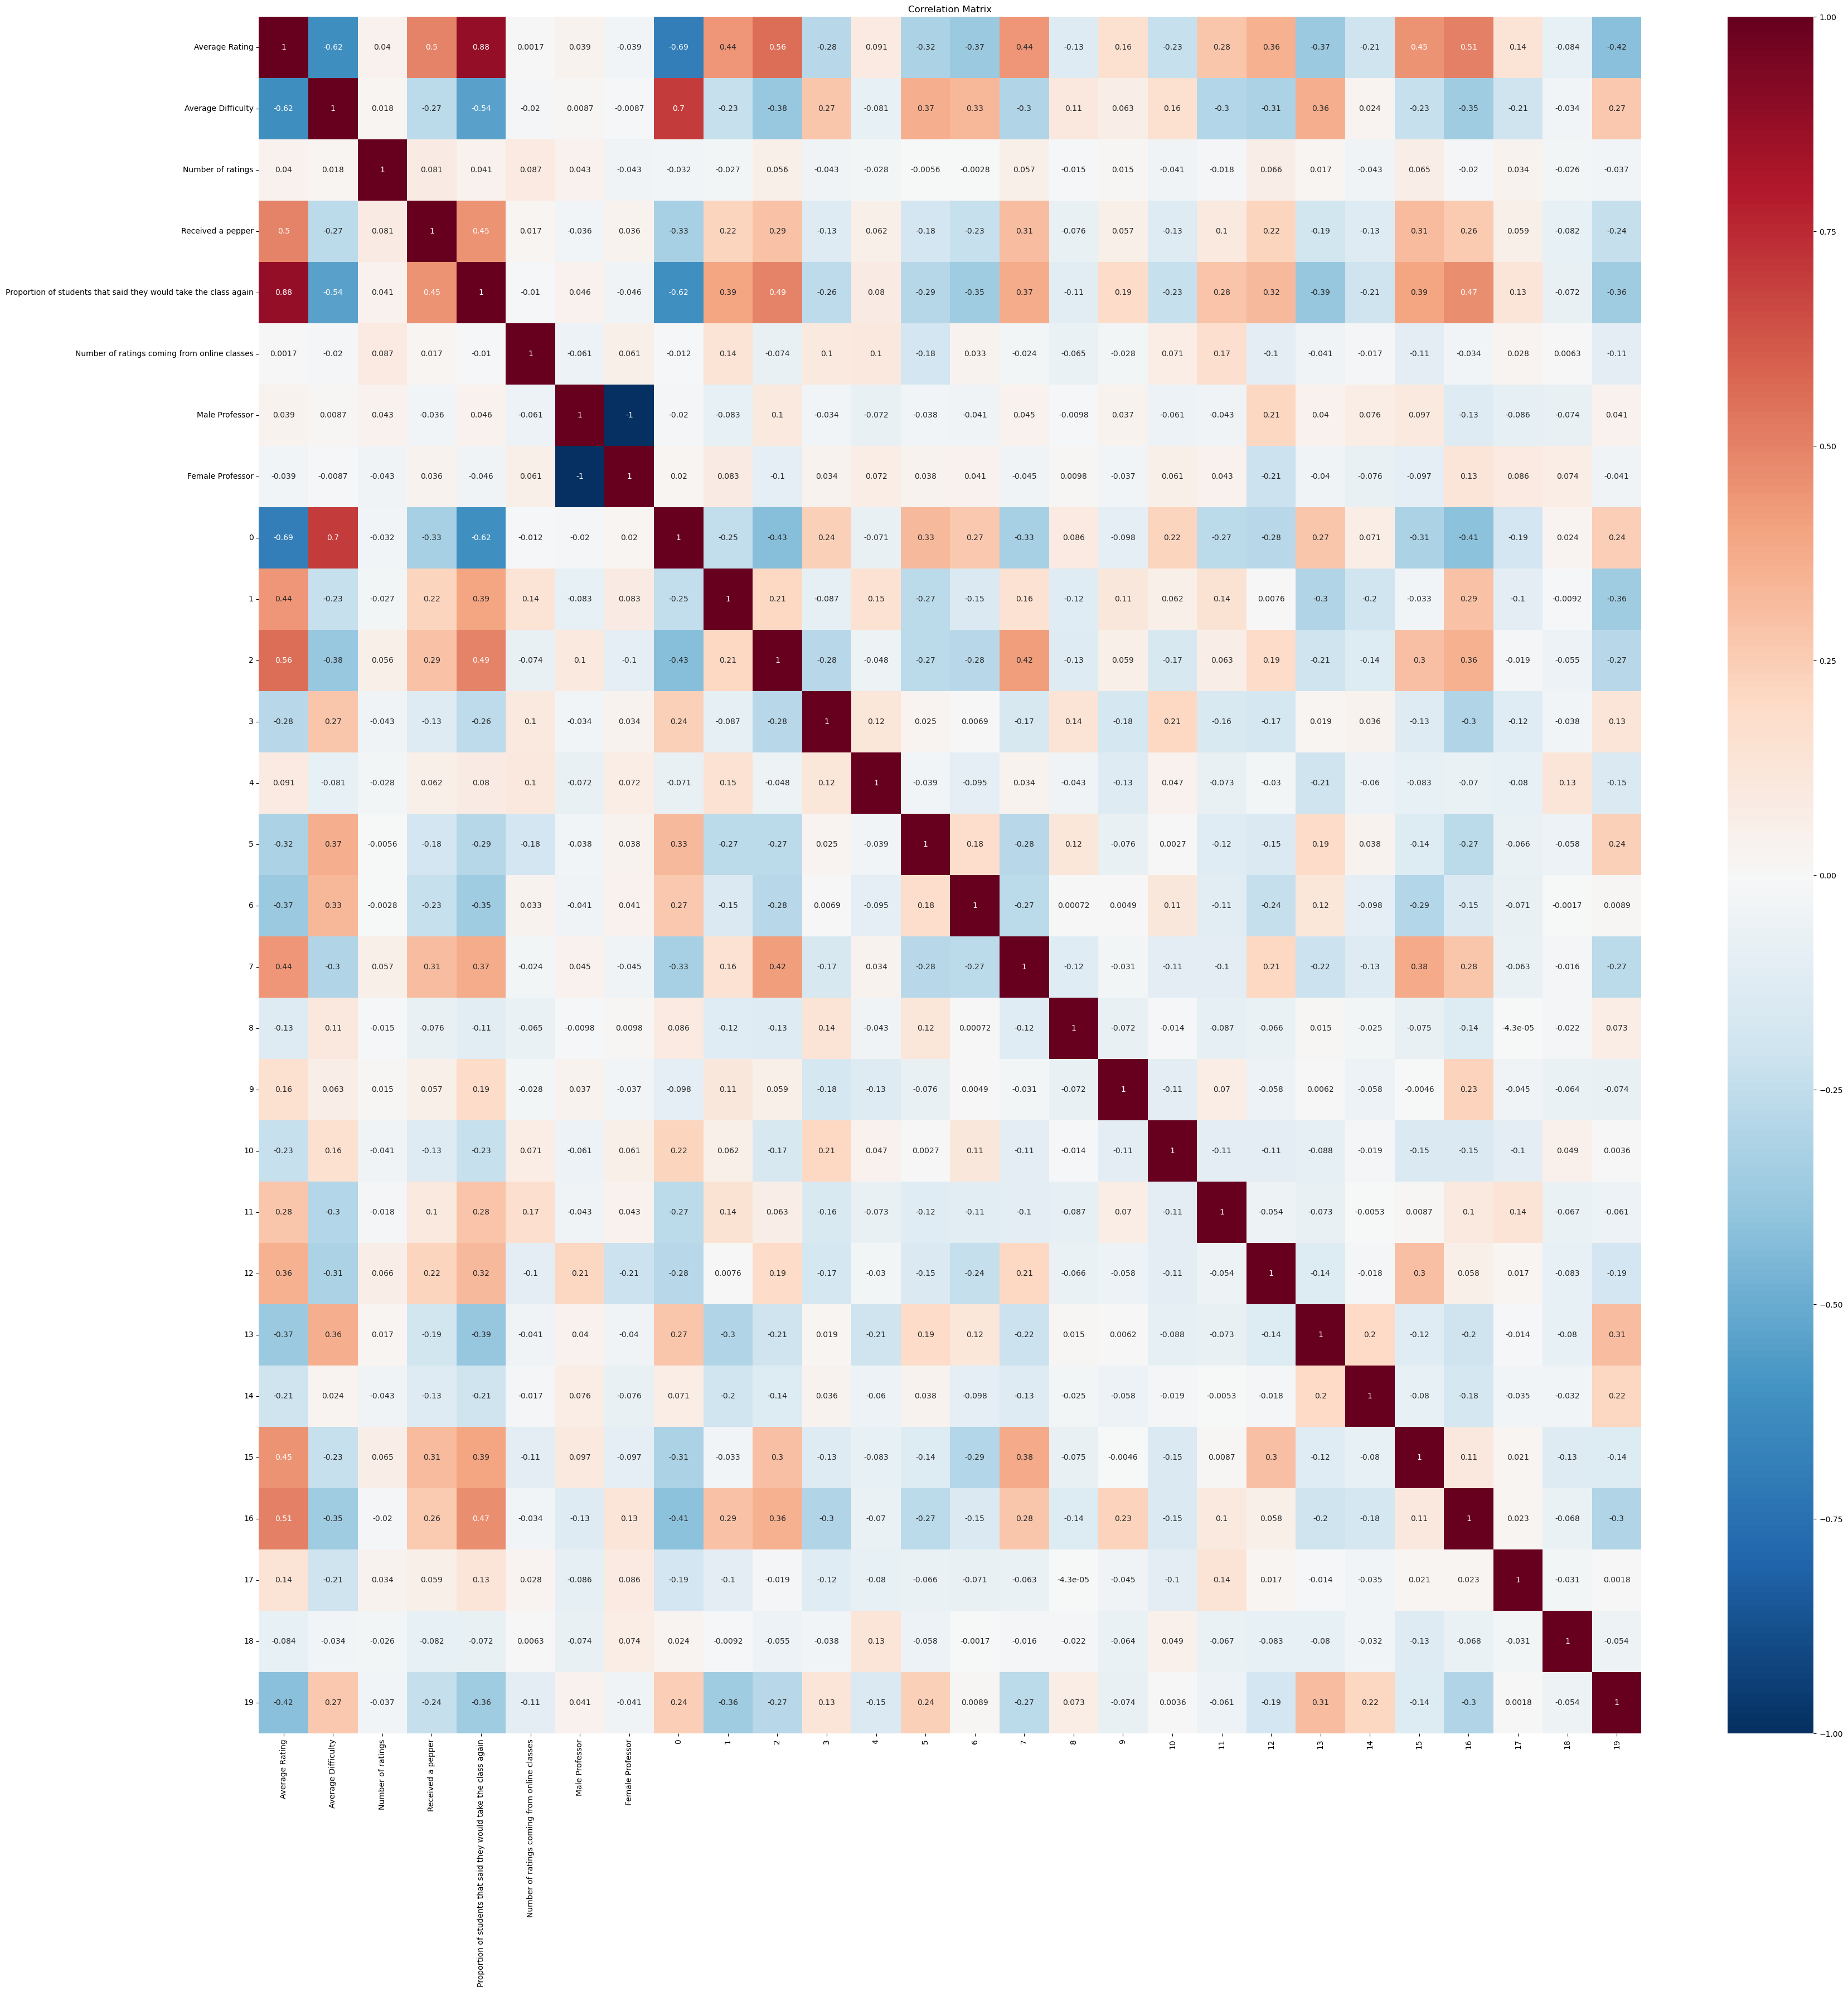

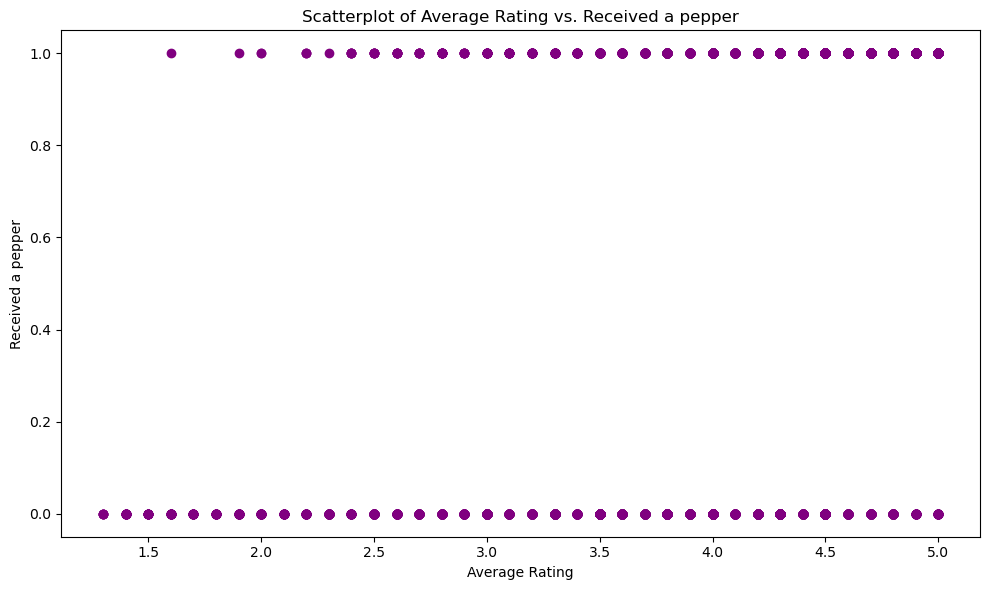

Classification Report (Single-Var Logistic):
              precision    recall  f1-score   support

         0.0       0.69      0.79      0.73       588
         1.0       0.76      0.65      0.70       605

    accuracy                           0.72      1193
   macro avg       0.72      0.72      0.72      1193
weighted avg       0.72      0.72      0.72      1193

Coefficient (beta1): 1.7182
Intercept: -6.9748
Odds multiplier (exp(beta1)): 5.5745
Intercept as odds => exp(intercept): 0.0009


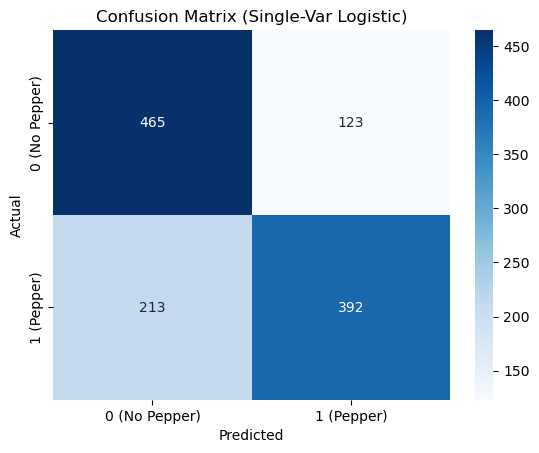

/var/folders/g3/nf_q_x0d0q3_12n_qrkr73m80000gn/T/ipykernel_12328/3778478790.py:147: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_array = np.linspace(X_train.min()[0], X_train.max()[0], 100)


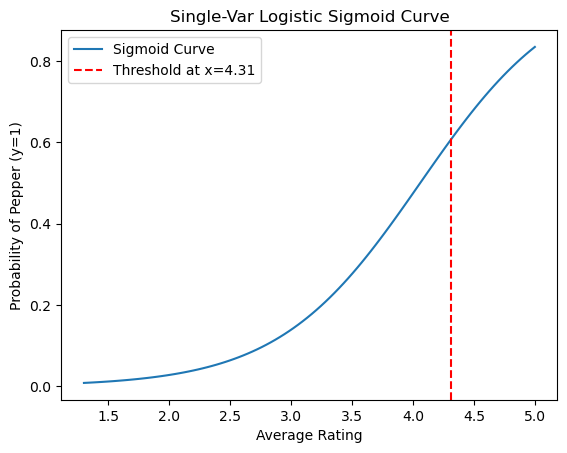

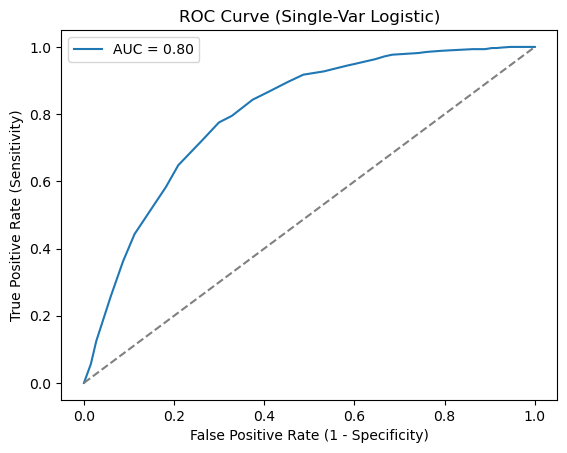

Optimal Threshold (Youden's J): 0.560

Classification Report (Multi-Var Logistic):
              precision    recall  f1-score   support

         0.0       0.79      0.68      0.73       588
         1.0       0.72      0.83      0.77       605

    accuracy                           0.75      1193
   macro avg       0.76      0.75      0.75      1193
weighted avg       0.76      0.75      0.75      1193


Coefficients (log scale):
[[ 4.25222426  1.08075115  0.84884081 -0.11262724  0.15126059 -0.20608115
   0.13578657  0.4306955  -0.14450448 -0.54667093  1.22244903 -0.20327933
  -0.45460472 -0.51532197 -0.09203666  0.35604443 -0.16275165 -0.27565235
   1.09421835  0.4568929   0.29996403 -0.96804621 -0.72502356]]
Exp of Coefficients (odds multipliers):
[[70.26151833  2.94689228  2.33693633  0.89348365  1.16329976  0.81376704
   1.1454374   1.53832705  0.86545103  0.57887372  3.39549321  0.81605027
   0.6346988   0.59730825  0.91207171  1.42767098  0.84980221  0.75907678
   2.9868471   

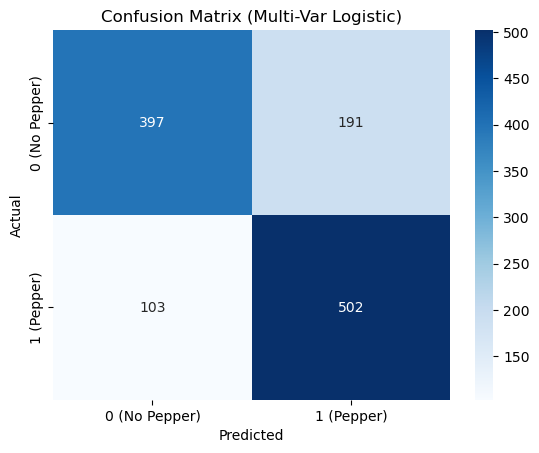

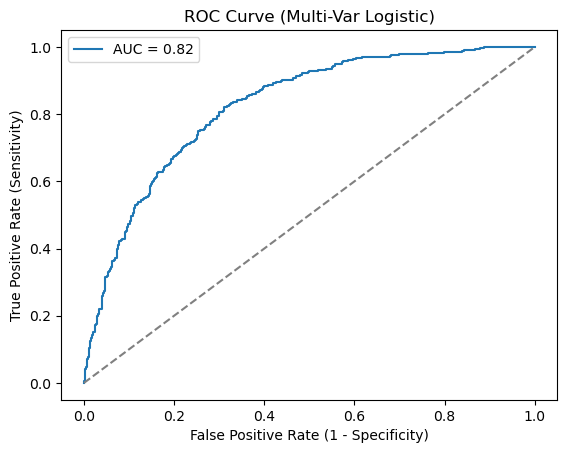

Optimal Threshold (Youden's J) for multi-var logistic: 0.486
Classification Report (SVM):
              precision    recall  f1-score   support

         0.0       0.78      0.66      0.72       588
         1.0       0.72      0.82      0.76       605

    accuracy                           0.74      1193
   macro avg       0.75      0.74      0.74      1193
weighted avg       0.75      0.74      0.74      1193


SVM Coefficients (w): [ 4.00113443  0.95739856  0.73493586 -0.09882987  0.06383449 -0.07091684
  0.21157476  0.20502628 -0.11558351 -0.65526973  0.6361186  -0.27447391
 -0.26953658 -0.41942766 -0.0644852   0.21308664 -0.19602848 -0.01572192
  0.60596944  0.49161349  0.21883216 -0.89414176 -0.91178282]
SVM Intercept (b): -3.978734856345301


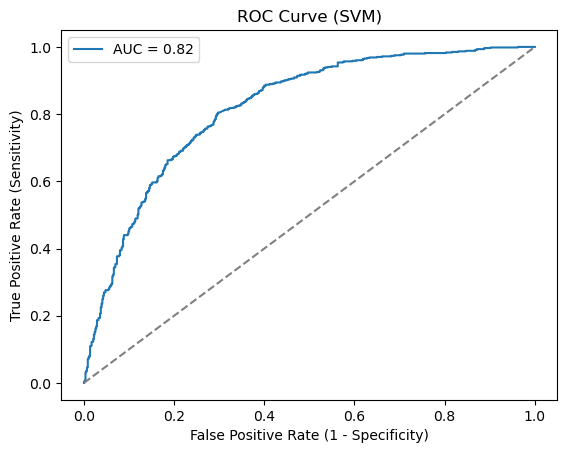

In [41]:
# 1. Instantiate the class with your dataframes (df_capstone, tagsdf)
#    Suppose df_capstone_dropped_final = ... and tagsdf = ...
analysis = PepperAnalysis(df_capstone, tagsdf, seed=seed)

# 2. Preprocess data (merge, drop NAs, compute proportions, filter for male/female, etc.)
analysis.preprocess_data()

# 3. (Optional) Plot correlation matrix to see the big picture
analysis.plot_correlation_matrix()

# 4. (Optional) Plot scatter for single variable
analysis.plot_scatter_single(x_col='Average Rating', y_col='Received a pepper')

# 5. Single-variable logistic regression
#    You can supply a threshold if you want something other than 0.5
analysis.logistic_regression_single_var(
    x_col='Average Rating', 
    y_col='Received a pepper', 
    threshold=0.607  # or pick from ROC
)

# 6. Multi-variable logistic regression (by default, it will drop certain columns)
#    Adjust threshold as needed, or see the "optimal" from the ROC curve
analysis.logistic_regression_multi_var(threshold=0.465)

# 7. Train a linear SVM for comparison
analysis.train_svm()
